In [1]:
%matplotlib inline
import pyNN.nest as sim
from pyNN.utility import get_simulator, normalized_filename

def get_pop():

    SENSORPARAMS = {'v_rest': -60.5,
                    'cm': 0.025,
                    'tau_m': 10.,
                    'tau_refrac': 10.0,
                    'tau_syn_E': 2.5,
                    'tau_syn_I': 2.5,
                    'e_rev_E': 0.0,
                    'e_rev_I': -75.0,
                    'v_thresh': -60.0,
                    'v_reset': -60.5}

    GO_ON_PARAMS = {'v_rest': -60.5,
                    'cm': 0.025,
                    'tau_m': 10.0,
                    'e_rev_E': 0.0,
                    'e_rev_I': -75.0,
                    'v_reset': -61.6,
                    'v_thresh': -60.51,
                    'tau_refrac': 10.0,
                    'tau_syn_E': 2.5,
                    'tau_syn_I': 2.5}

    population = sim.Population(8, sim.IF_cond_alpha())
    population[0:5].set(**SENSORPARAMS)
    population[5:6].set(**GO_ON_PARAMS)
    population[6:8].set(**SENSORPARAMS)

    syn_params = {'U': 1.0, 'tau_rec': 1.0, 'tau_facil': 1.0}

    # Synaptic weights
    WEIGHT_RED_TO_ACTOR = 1.5e-4
    WEIGHT_RED_TO_GO_ON = 1.2e-3  # or -1.2e-3?
    WEIGHT_GREEN_BLUE_TO_ACTOR = 1.05e-4
    WEIGHT_GO_ON_TO_RIGHT_ACTOR = 1.4e-4
    DELAY = 1

    # Connect neurons
    CIRCUIT = population

    SYN = sim.TsodyksMarkramSynapse(weight=abs(WEIGHT_RED_TO_ACTOR),
                                    delay=DELAY, **syn_params)
    sim.Projection(presynaptic_population=CIRCUIT[2:3],
                   postsynaptic_population=CIRCUIT[7:8],
                   connector=sim.AllToAllConnector(),
                   synapse_type=SYN,
                   receptor_type='excitatory')
    sim.Projection(presynaptic_population=CIRCUIT[3:4],
                   postsynaptic_population=CIRCUIT[6:7],
                   connector=sim.AllToAllConnector(),
                   synapse_type=SYN,
                   receptor_type='excitatory')


    SYN = sim.TsodyksMarkramSynapse(weight=abs(WEIGHT_RED_TO_GO_ON),
                                    delay=DELAY, **syn_params)
    sim.Projection(presynaptic_population=CIRCUIT[0:2],
                   postsynaptic_population=CIRCUIT[4:5],
                   connector=sim.AllToAllConnector(),
                   synapse_type=SYN,
                   receptor_type='inhibitory')
    sim.Projection(presynaptic_population=CIRCUIT[0:2],
                   postsynaptic_population=CIRCUIT[5:6],
                   connector=sim.AllToAllConnector(),
                   synapse_type=SYN,
                   receptor_type='inhibitory')

    SYN = sim.TsodyksMarkramSynapse(weight=abs(WEIGHT_GREEN_BLUE_TO_ACTOR),
                                    delay=DELAY, **syn_params)
    sim.Projection(presynaptic_population=CIRCUIT[4:5],
                   postsynaptic_population=CIRCUIT[7:8],
                   connector=sim.AllToAllConnector(),
                   synapse_type=SYN,
                   receptor_type='excitatory')

    SYN = sim.TsodyksMarkramSynapse(weight=abs(WEIGHT_GO_ON_TO_RIGHT_ACTOR),
                                    delay=DELAY, **syn_params)
    sim.Projection(presynaptic_population=CIRCUIT[5:6],
                   postsynaptic_population=CIRCUIT[7:8],
                   connector=sim.AllToAllConnector(),
                   synapse_type=SYN,
                   receptor_type='excitatory')

    return population
    
def plot(population):
    vm = population.get_data().segments[0].filter(name="v")[0]
    from pyNN.utility.plotting import Figure, Panel
    from quantities import mV
    fig = Figure(
        Panel(vm, y_offset=-10 * mV, xticks=True, yticks=True,
              xlabel="Time (ms)", ylabel="Membrane potential (mV)",
              ylim=(-140, -50)),
        title="Current injection example",
        annotations="Simulated with nest"
    )

/opt/conda/lib/python3.7/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


<IPython.core.display.Javascript object>


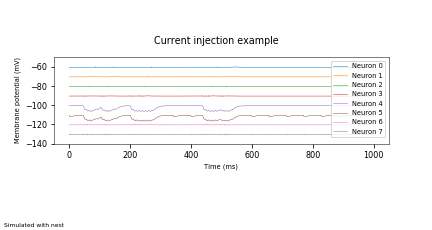

In [2]:
%matplotlib notebook


sim.setup(timestep=0.1,min_delay=0.1,max_delay=4.0)
population=get_pop()
sim.initialize(population, v=population.get('v_rest'))

sspoi = sim.create(sim.SpikeSourcePoisson,  {'start': 0.0, 'duration': 10000000000.0, 'rate': 0.0})
connE = sim.connect(sspoi, population[0], weight=60.0, receptor_type='excitatory',delay=2.0)
connE = sim.connect(sspoi, population[1], weight=0.6, receptor_type='excitatory',delay=2.0)
connE = sim.connect(sspoi, population[2], weight=0.06, receptor_type='excitatory',delay=2.0)
connE = sim.connect(sspoi, population[3], weight=0.006, receptor_type='excitatory',delay=2.0)


filename = normalized_filename("Results", "current_injection", "pkl", "nest")
sim.record('v', population, filename, annotations={'script_name': filename})

# === Run the simulation =====================================================


class SetRate(object):
    """
    A callback which changes the firing rate of a population of poisson
    processes at a fixed interval.
    """
    rate = 0

    def __init__(self, source, interval=20.0):
        assert isinstance(source.celltype, sim.SpikeSourcePoisson)
        self.source = source
        self.interval = interval
        
    def __call__(self, t):
        try:
            if t%1000 < 500:
                self.source.set(rate=self.rate + 10)
            else:
                self.source.set(rate=0)
        except StopIteration:
            pass
        return t + self.interval

sim.run(1000.0, callbacks=[SetRate(sspoi)])


vm = population.get_data().segments[0].filter(name="v")[0]
from pyNN.utility.plotting import Figure, Panel
from quantities import mV
fig = Figure(
    Panel(vm, y_offset=-10 * mV, xticks=True, yticks=True,
          xlabel="Time (ms)", ylabel="Membrane potential (mV)",
          ylim=(-140, -50)),
    title="Current injection example",
    annotations="Simulated with nest"
)

In [ ]:
from pyNN.utility import get_script_args
from pyNN.errors import RecordingError
from pyNN.nest import *

setup(timestep=0.1,min_delay=0.1,max_delay=4.0)

ifcell = create(IF_cond_exp, {  'i_offset' : 0.1,    'tau_refrac' : 3.0,
                                'v_thresh' : -51.0,  'tau_syn_E'  : 2.0,
                                'tau_syn_I': 5.0,    'v_reset'    : -70.0,
                                'e_rev_E'  : 0.,     'e_rev_I'    : -80.})

spike_sourceI = create(SpikeSourcePoisson,  {'start': 0.0, 'duration': 10000000000.0, 'rate': 100.0})
spike_sourceE = create(SpikeSourcePoisson,  {'start': 0.0, 'duration': 10000000000.0, 'rate': 1000.0})

connE = connect(spike_sourceE, ifcell, weight=0.006, receptor_type='excitatory',delay=2.0)
connI = connect(spike_sourceI, ifcell, weight=0.02, receptor_type ='inhibitory',delay=4.0)
    
record_v(ifcell, "Results/IF_cond_exp_nest.v")
try:
    record_gsyn(ifcell, "Results/IF_cond_exp_nest.gsyn")
except (NotImplementedError, RecordingError):
    pass
run(200.0)

# %matplotlib inline
# plot(ifcell)